# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = "{'task_type': 'GPU'}" # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = "{'task_type': 'GPU'}" # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/CATB/Demo Tuning/DEMO_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/CATB/Demo Tuning/DEMO_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LdrGetProcedureAddress,LookupAccountSidW,LdrGetProcedureAddress,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress
1,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
3,0,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile
4,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()))
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050737


Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5413920	test: 0.5415209	best: 0.5415209 (0)	total: 229ms	remaining: 3m 48s
1:	total: 423ms	remaining: 3m 31s
2:	total: 610ms	remaining: 3m 22s
3:	total: 785ms	remaining: 3m 15s
4:	total: 965ms	remaining: 3m 11s
5:	learn: 0.1829210	test: 0.1835306	best: 0.1835306 (5)	total: 1.15s	remaining: 3m 10s
6:	total: 1.33s	remaining: 3m 9s
7:	total: 1.52s	remaining: 3m 8s
8:	total: 1.7s	remaining: 3m 7s
9:	total: 1.9s	remaining: 3m 8s
10:	learn: 0.0842546	test: 0.0845458	best: 0.0845458 (10)	total: 2.13s	remaining: 3m 11s
11:	total: 2.31s	remaining: 3m 9s
12:	total: 2.49s	remaining: 3m 9s
13:	total: 2.76s	remaining: 3m 14s
14:	total: 2.94s	remaining: 3m 13s
15:	learn: 0.0539803	test: 0.0545215	best: 0.0545215 (15)	total: 3.13s	remaining: 3m 12s
16:	total: 3.31s	remaining: 3m 11s
17:	total: 3.49s	remaining: 3m 10s
18:	total: 3.67s	remaining: 3m 9s
19:	total: 3.87s	remaining: 3m 9s
20:	learn: 0.0404568	test: 0.0413355	best: 0.0413355 (20)	total: 4.09s	remaining: 3m 10s
21:	total: 4.28s	

180:	learn: 0.0138281	test: 0.0207062	best: 0.0207062 (180)	total: 33.3s	remaining: 2m 30s
181:	total: 33.5s	remaining: 2m 30s
182:	total: 33.7s	remaining: 2m 30s
183:	total: 33.9s	remaining: 2m 30s
184:	total: 34s	remaining: 2m 29s
185:	learn: 0.0136148	test: 0.0206717	best: 0.0206717 (185)	total: 34.3s	remaining: 2m 29s
186:	total: 34.4s	remaining: 2m 29s
187:	total: 34.6s	remaining: 2m 29s
188:	total: 34.8s	remaining: 2m 29s
189:	total: 35s	remaining: 2m 29s
190:	learn: 0.0133878	test: 0.0205366	best: 0.0205366 (190)	total: 35.1s	remaining: 2m 28s
191:	total: 35.3s	remaining: 2m 28s
192:	total: 35.5s	remaining: 2m 28s
193:	total: 35.7s	remaining: 2m 28s
194:	total: 35.9s	remaining: 2m 28s
195:	learn: 0.0132170	test: 0.0204856	best: 0.0204856 (195)	total: 36s	remaining: 2m 27s
196:	total: 36.2s	remaining: 2m 27s
197:	total: 36.4s	remaining: 2m 27s
198:	total: 36.6s	remaining: 2m 27s
199:	total: 36.7s	remaining: 2m 26s
200:	learn: 0.0130415	test: 0.0204455	best: 0.0204455 (200)	total:

356:	total: 1m 5s	remaining: 1m 57s
357:	total: 1m 5s	remaining: 1m 57s
358:	total: 1m 5s	remaining: 1m 57s
359:	total: 1m 5s	remaining: 1m 56s
360:	learn: 0.0089487	test: 0.0190495	best: 0.0190495 (360)	total: 1m 5s	remaining: 1m 56s
361:	total: 1m 6s	remaining: 1m 56s
362:	total: 1m 6s	remaining: 1m 56s
363:	total: 1m 6s	remaining: 1m 56s
364:	total: 1m 6s	remaining: 1m 55s
365:	learn: 0.0088610	test: 0.0190287	best: 0.0190287 (365)	total: 1m 6s	remaining: 1m 55s
366:	total: 1m 7s	remaining: 1m 55s
367:	total: 1m 7s	remaining: 1m 55s
368:	total: 1m 7s	remaining: 1m 55s
369:	total: 1m 7s	remaining: 1m 55s
370:	learn: 0.0087645	test: 0.0190433	best: 0.0190287 (365)	total: 1m 7s	remaining: 1m 54s
371:	total: 1m 7s	remaining: 1m 54s
372:	total: 1m 8s	remaining: 1m 54s
373:	total: 1m 8s	remaining: 1m 54s
374:	total: 1m 8s	remaining: 1m 54s
375:	learn: 0.0086657	test: 0.0190007	best: 0.0190007 (375)	total: 1m 8s	remaining: 1m 54s
376:	total: 1m 8s	remaining: 1m 53s
377:	total: 1m 9s	remain

528:	total: 1m 36s	remaining: 1m 25s
529:	total: 1m 36s	remaining: 1m 25s
530:	learn: 0.0063976	test: 0.0186892	best: 0.0186892 (530)	total: 1m 36s	remaining: 1m 25s
531:	total: 1m 36s	remaining: 1m 25s
532:	total: 1m 36s	remaining: 1m 24s
533:	total: 1m 37s	remaining: 1m 24s
534:	total: 1m 37s	remaining: 1m 24s
535:	learn: 0.0063431	test: 0.0186725	best: 0.0186725 (535)	total: 1m 37s	remaining: 1m 24s
536:	total: 1m 37s	remaining: 1m 24s
537:	total: 1m 37s	remaining: 1m 24s
538:	total: 1m 38s	remaining: 1m 23s
539:	total: 1m 38s	remaining: 1m 23s
540:	learn: 0.0062924	test: 0.0186952	best: 0.0186725 (535)	total: 1m 38s	remaining: 1m 23s
541:	total: 1m 38s	remaining: 1m 23s
542:	total: 1m 38s	remaining: 1m 23s
543:	total: 1m 38s	remaining: 1m 22s
544:	total: 1m 39s	remaining: 1m 22s
545:	learn: 0.0062381	test: 0.0186900	best: 0.0186725 (535)	total: 1m 39s	remaining: 1m 22s
546:	total: 1m 39s	remaining: 1m 22s
547:	total: 1m 39s	remaining: 1m 22s
548:	total: 1m 39s	remaining: 1m 22s
549

704:	total: 2m 8s	remaining: 53.7s
705:	learn: 0.0047893	test: 0.0186109	best: 0.0185538 (605)	total: 2m 8s	remaining: 53.5s
706:	total: 2m 8s	remaining: 53.3s
707:	total: 2m 8s	remaining: 53.1s
708:	total: 2m 8s	remaining: 52.9s
709:	total: 2m 9s	remaining: 52.8s
710:	learn: 0.0047559	test: 0.0186148	best: 0.0185538 (605)	total: 2m 9s	remaining: 52.6s
711:	total: 2m 9s	remaining: 52.4s
712:	total: 2m 9s	remaining: 52.2s
713:	total: 2m 9s	remaining: 52s
714:	total: 2m 10s	remaining: 51.8s
715:	learn: 0.0047149	test: 0.0186134	best: 0.0185538 (605)	total: 2m 10s	remaining: 51.7s
716:	total: 2m 10s	remaining: 51.5s
717:	total: 2m 10s	remaining: 51.3s
718:	total: 2m 10s	remaining: 51.1s
719:	total: 2m 10s	remaining: 50.9s
720:	learn: 0.0046705	test: 0.0186249	best: 0.0185538 (605)	total: 2m 11s	remaining: 50.8s
721:	total: 2m 11s	remaining: 50.6s
722:	total: 2m 11s	remaining: 50.4s
723:	total: 2m 11s	remaining: 50.2s
724:	total: 2m 11s	remaining: 50s
725:	learn: 0.0046401	test: 0.0186136	

881:	total: 2m 40s	remaining: 21.4s
882:	total: 2m 40s	remaining: 21.3s
883:	total: 2m 40s	remaining: 21.1s
884:	total: 2m 40s	remaining: 20.9s
885:	learn: 0.0036794	test: 0.0187004	best: 0.0185538 (605)	total: 2m 40s	remaining: 20.7s
886:	total: 2m 41s	remaining: 20.5s
887:	total: 2m 41s	remaining: 20.3s
888:	total: 2m 41s	remaining: 20.2s
889:	total: 2m 41s	remaining: 20s
890:	learn: 0.0036558	test: 0.0187098	best: 0.0185538 (605)	total: 2m 41s	remaining: 19.8s
891:	total: 2m 42s	remaining: 19.6s
892:	total: 2m 42s	remaining: 19.4s
893:	total: 2m 42s	remaining: 19.3s
894:	total: 2m 42s	remaining: 19.1s
895:	learn: 0.0036318	test: 0.0187161	best: 0.0185538 (605)	total: 2m 42s	remaining: 18.9s
896:	total: 2m 42s	remaining: 18.7s
897:	total: 2m 43s	remaining: 18.5s
898:	total: 2m 43s	remaining: 18.3s
899:	total: 2m 43s	remaining: 18.2s
900:	learn: 0.0036085	test: 0.0187145	best: 0.0185538 (605)	total: 2m 43s	remaining: 18s
901:	total: 2m 43s	remaining: 17.8s
902:	total: 2m 43s	remaining

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

              precision    recall  f1-score   support

           0     0.9983    0.9908    0.9945     11530
           1     0.9909    0.9983    0.9946     11578

    accuracy                         0.9945     23108
   macro avg     0.9946    0.9945    0.9945     23108
weighted avg     0.9946    0.9945    0.9945     23108



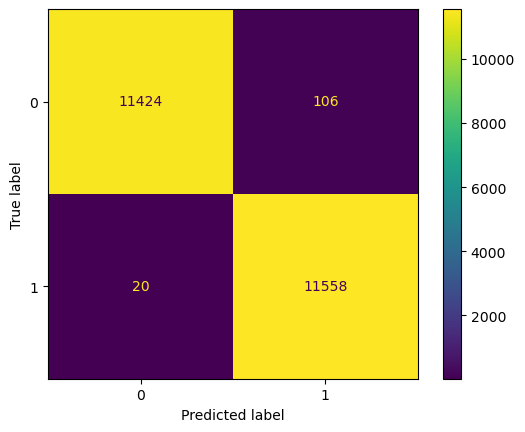

In [11]:
y_pred = tb_catb.predict(X_tb_validate)
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

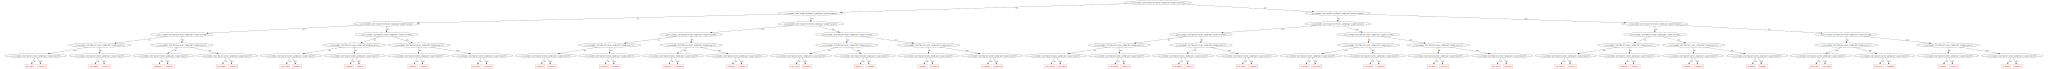

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree"+".svg")
display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()))
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050737


Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5400013	test: 0.5398929	best: 0.5398929 (0)	total: 117ms	remaining: 1m 56s
1:	total: 222ms	remaining: 1m 50s
2:	total: 323ms	remaining: 1m 47s
3:	total: 426ms	remaining: 1m 45s
4:	total: 525ms	remaining: 1m 44s
5:	learn: 0.1856722	test: 0.1849335	best: 0.1849335 (5)	total: 625ms	remaining: 1m 43s
6:	total: 729ms	remaining: 1m 43s
7:	total: 823ms	remaining: 1m 42s
8:	total: 916ms	remaining: 1m 40s
9:	total: 1.01s	remaining: 1m 40s
10:	learn: 0.0839100	test: 0.0835345	best: 0.0835345 (10)	total: 1.11s	remaining: 1m 40s
11:	total: 1.21s	remaining: 1m 39s
12:	total: 1.32s	remaining: 1m 40s
13:	total: 1.42s	remaining: 1m 39s
14:	total: 1.51s	remaining: 1m 39s
15:	learn: 0.0529537	test: 0.0529843	best: 0.0529843 (15)	total: 1.62s	remaining: 1m 39s
16:	total: 1.72s	remaining: 1m 39s
17:	total: 1.81s	remaining: 1m 38s
18:	total: 1.91s	remaining: 1m 38s
19:	total: 2.02s	remaining: 1m 38s
20:	learn: 0.0389788	test: 0.0394370	best: 0.0394370 (20)	total: 2.12s	remaining: 1m 39s
21:	tot

179:	total: 18s	remaining: 1m 22s
180:	learn: 0.0145220	test: 0.0200216	best: 0.0200216 (180)	total: 18.1s	remaining: 1m 22s
181:	total: 18.2s	remaining: 1m 21s
182:	total: 18.3s	remaining: 1m 21s
183:	total: 18.4s	remaining: 1m 21s
184:	total: 18.5s	remaining: 1m 21s
185:	learn: 0.0143289	test: 0.0199795	best: 0.0199795 (185)	total: 18.6s	remaining: 1m 21s
186:	total: 18.7s	remaining: 1m 21s
187:	total: 18.8s	remaining: 1m 21s
188:	total: 18.9s	remaining: 1m 21s
189:	total: 19s	remaining: 1m 21s
190:	learn: 0.0141960	test: 0.0199225	best: 0.0199225 (190)	total: 19.1s	remaining: 1m 21s
191:	total: 19.2s	remaining: 1m 20s
192:	total: 19.3s	remaining: 1m 20s
193:	total: 19.5s	remaining: 1m 20s
194:	total: 19.5s	remaining: 1m 20s
195:	learn: 0.0140514	test: 0.0198413	best: 0.0198413 (195)	total: 19.7s	remaining: 1m 20s
196:	total: 19.7s	remaining: 1m 20s
197:	total: 19.8s	remaining: 1m 20s
198:	total: 19.9s	remaining: 1m 20s
199:	total: 20.1s	remaining: 1m 20s
200:	learn: 0.0139504	test: 

356:	total: 35.6s	remaining: 1m 4s
357:	total: 35.7s	remaining: 1m 4s
358:	total: 35.8s	remaining: 1m 3s
359:	total: 35.9s	remaining: 1m 3s
360:	learn: 0.0104428	test: 0.0188528	best: 0.0188528 (360)	total: 36s	remaining: 1m 3s
361:	total: 36.1s	remaining: 1m 3s
362:	total: 36.2s	remaining: 1m 3s
363:	total: 36.3s	remaining: 1m 3s
364:	total: 36.4s	remaining: 1m 3s
365:	learn: 0.0103621	test: 0.0188124	best: 0.0188124 (365)	total: 36.5s	remaining: 1m 3s
366:	total: 36.6s	remaining: 1m 3s
367:	total: 36.7s	remaining: 1m 3s
368:	total: 36.8s	remaining: 1m 2s
369:	total: 36.9s	remaining: 1m 2s
370:	learn: 0.0103017	test: 0.0187832	best: 0.0187832 (370)	total: 37s	remaining: 1m 2s
371:	total: 37.1s	remaining: 1m 2s
372:	total: 37.2s	remaining: 1m 2s
373:	total: 37.3s	remaining: 1m 2s
374:	total: 37.4s	remaining: 1m 2s
375:	learn: 0.0102480	test: 0.0187614	best: 0.0187614 (375)	total: 37.5s	remaining: 1m 2s
376:	total: 37.6s	remaining: 1m 2s
377:	total: 37.7s	remaining: 1m 2s
378:	total: 37

539:	total: 54s	remaining: 46s
540:	learn: 0.0081881	test: 0.0183217	best: 0.0183101 (535)	total: 54.1s	remaining: 45.9s
541:	total: 54.2s	remaining: 45.8s
542:	total: 54.3s	remaining: 45.7s
543:	total: 54.4s	remaining: 45.6s
544:	total: 54.5s	remaining: 45.5s
545:	learn: 0.0081473	test: 0.0183147	best: 0.0183101 (535)	total: 54.6s	remaining: 45.4s
546:	total: 54.7s	remaining: 45.3s
547:	total: 54.8s	remaining: 45.2s
548:	total: 54.9s	remaining: 45.1s
549:	total: 55s	remaining: 45s
550:	learn: 0.0080961	test: 0.0182911	best: 0.0182911 (550)	total: 55.1s	remaining: 44.9s
551:	total: 55.2s	remaining: 44.8s
552:	total: 55.3s	remaining: 44.7s
553:	total: 55.4s	remaining: 44.6s
554:	total: 55.5s	remaining: 44.5s
555:	learn: 0.0080363	test: 0.0182928	best: 0.0182911 (550)	total: 55.6s	remaining: 44.4s
556:	total: 55.7s	remaining: 44.3s
557:	total: 55.8s	remaining: 44.2s
558:	total: 55.9s	remaining: 44.1s
559:	total: 56s	remaining: 44s
560:	learn: 0.0079734	test: 0.0182979	best: 0.0182911 (55

719:	total: 1m 12s	remaining: 28.1s
720:	learn: 0.0064002	test: 0.0181055	best: 0.0180851 (690)	total: 1m 12s	remaining: 28s
721:	total: 1m 12s	remaining: 27.9s
722:	total: 1m 12s	remaining: 27.8s
723:	total: 1m 12s	remaining: 27.7s
724:	total: 1m 12s	remaining: 27.6s
725:	learn: 0.0063782	test: 0.0181008	best: 0.0180851 (690)	total: 1m 12s	remaining: 27.5s
726:	total: 1m 13s	remaining: 27.4s
727:	total: 1m 13s	remaining: 27.3s
728:	total: 1m 13s	remaining: 27.2s
729:	total: 1m 13s	remaining: 27.1s
730:	learn: 0.0063395	test: 0.0181400	best: 0.0180851 (690)	total: 1m 13s	remaining: 27s
731:	total: 1m 13s	remaining: 26.9s
732:	total: 1m 13s	remaining: 26.8s
733:	total: 1m 13s	remaining: 26.7s
734:	total: 1m 13s	remaining: 26.6s
735:	learn: 0.0063083	test: 0.0181327	best: 0.0180851 (690)	total: 1m 13s	remaining: 26.5s
736:	total: 1m 13s	remaining: 26.4s
737:	total: 1m 14s	remaining: 26.3s
738:	total: 1m 14s	remaining: 26.2s
739:	total: 1m 14s	remaining: 26.1s
740:	learn: 0.0062519	test: 

895:	learn: 0.0053052	test: 0.0181920	best: 0.0180851 (690)	total: 1m 30s	remaining: 10.5s
896:	total: 1m 30s	remaining: 10.4s
897:	total: 1m 30s	remaining: 10.3s
898:	total: 1m 30s	remaining: 10.2s
899:	total: 1m 30s	remaining: 10.1s
900:	learn: 0.0052824	test: 0.0181839	best: 0.0180851 (690)	total: 1m 30s	remaining: 9.96s
901:	total: 1m 30s	remaining: 9.86s
902:	total: 1m 30s	remaining: 9.76s
903:	total: 1m 30s	remaining: 9.66s
904:	total: 1m 31s	remaining: 9.56s
905:	learn: 0.0052575	test: 0.0181794	best: 0.0180851 (690)	total: 1m 31s	remaining: 9.46s
906:	total: 1m 31s	remaining: 9.36s
907:	total: 1m 31s	remaining: 9.26s
908:	total: 1m 31s	remaining: 9.16s
909:	total: 1m 31s	remaining: 9.06s
910:	learn: 0.0052190	test: 0.0181957	best: 0.0180851 (690)	total: 1m 31s	remaining: 8.96s
911:	total: 1m 31s	remaining: 8.86s
912:	total: 1m 31s	remaining: 8.76s
913:	total: 1m 32s	remaining: 8.66s
914:	total: 1m 32s	remaining: 8.55s
915:	learn: 0.0052003	test: 0.0181954	best: 0.0180851 (690)	

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

              precision    recall  f1-score   support

           0     0.9985    0.9918    0.9952     11530
           1     0.9919    0.9985    0.9952     11578

    accuracy                         0.9952     23108
   macro avg     0.9952    0.9952    0.9952     23108
weighted avg     0.9952    0.9952    0.9952     23108



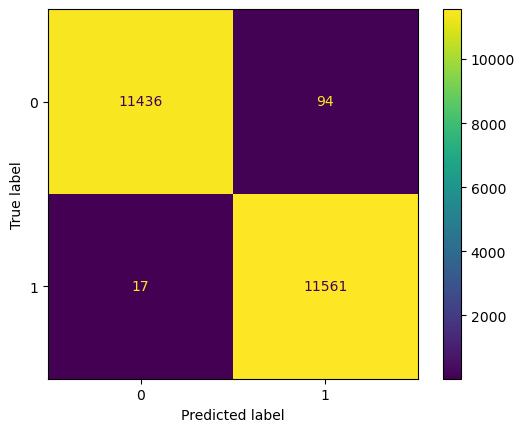

In [14]:
y_pred = ib_catb.predict(X_ib_validate)
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

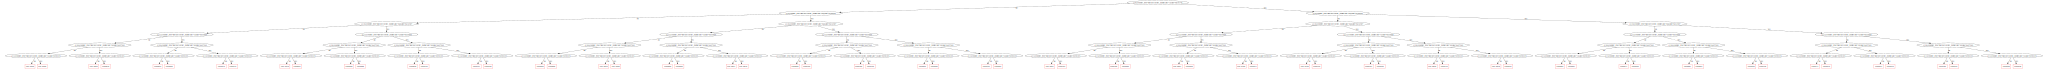

In [15]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree"+".svg")
tree

In [16]:
logging("\n")